In [15]:
#!unzip Acordes.zip

In [16]:
# Célula 1: Importação de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
import glob
import math
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [17]:
# Célula 2: Importação e Estruturação dos Dados de Áudio
def carregar_arquivos_audio(caminho_dados):
    caminhos_arquivos = []
    rotulos = []

    # Busca todos os arquivos .wav no diretório
    arquivos_wav = glob.glob(os.path.join(caminho_dados, "*.wav"))

    for caminho_arquivo in sorted(arquivos_wav):
        nome_arquivo = os.path.basename(caminho_arquivo).lower()

        # Determina o rótulo baseado no nome do arquivo
        if "major" in nome_arquivo:
            rotulo = 1  # Classificação para acorde maior
        elif "minor" in nome_arquivo:
            rotulo = 0  # Classificação para acorde menor
        else:
            continue  # Pula arquivos que não se encaixam nos critérios

        caminhos_arquivos.append(caminho_arquivo)
        rotulos.append(rotulo)

    return caminhos_arquivos, np.array(rotulos)

print("Iniciando carregamento dos arquivos de áudio...")
caminhos_audio, rotulos_dados = carregar_arquivos_audio("Acordes")

print(f"\nEstatísticas do conjunto de dados:")
print(f"   Quantidade total de amostras: {len(rotulos_dados)}")
print(f"   Acordes classificados como maiores: {np.count_nonzero(rotulos_dados)}")
print(f"   Acordes classificados como menores: {len(rotulos_dados) - np.count_nonzero(rotulos_dados)}")

Iniciando carregamento dos arquivos de áudio...

Estatísticas do conjunto de dados:
   Quantidade total de amostras: 100
   Acordes classificados como maiores: 50
   Acordes classificados como menores: 50


In [18]:
# Bloco 3: Extração de Características Musicais
def extrair_caracteristicas(sinal_audio, taxa_amostragem=22050):
    caracteristicas = {}

    # 1. Extração de Chroma CQT (Constant-Q Transform)
    chroma_cqt = librosa.feature.chroma_cqt(y=sinal_audio, sr=taxa_amostragem)
    media_chroma = chroma_cqt.mean(axis=1) + 1e-9  # prevenção contra divisão por zero

    # Armazena médias do chroma para cada uma das 12 classes de altura
    for indice in range(12):
        caracteristicas[f'chroma_cqt_media_{indice}'] = media_chroma[indice]

    # 2. Análise Tonnetz (rede tonal harmônica)
    componente_harmonico = librosa.effects.harmonic(sinal_audio)
    tonnetz = librosa.feature.tonnetz(y=componente_harmonico, sr=taxa_amostragem)

    # Calcula média e desvio padrão para cada dimensão do tonnetz
    for dim in range(5):
        caracteristicas[f'tonnetz_media_{dim+1}'] = np.mean(tonnetz[dim])
        caracteristicas[f'tonnetz_desvio_{dim+1}'] = np.std(tonnetz[dim])

    # 3. Cálculo de Proporções Intervalares
    indice_fundamental = np.argmax(media_chroma)

    def obter_energia(deslocamento_semitons):
        return media_chroma[(indice_fundamental + deslocamento_semitons) % 12]

    # Razões entre intervalos característicos
    caracteristicas['proporcao_terca_menor'] = obter_energia(3) / media_chroma[indice_fundamental]
    caracteristicas['proporcao_terca_maior'] = obter_energia(4) / media_chroma[indice_fundamental]
    caracteristicas['razao_menor_maior'] = caracteristicas['proporcao_terca_menor'] / caracteristicas['proporcao_terca_maior']

    return caracteristicas

def processar_todas_caracteristicas():
    global dataframe_caracteristicas

    lista_caracteristicas = []
    total_arquivos = len(caminhos_audio)

    for indice, caminho_arquivo in enumerate(caminhos_audio):
        print(f"\r Processando características de {total_arquivos} arquivos... ({indice+1}/{total_arquivos})", end="", flush=True)

        sinal, _ = librosa.load(caminho_arquivo, sr=22050)
        caracteristicas_extraidas = extrair_caracteristicas(sinal)
        lista_caracteristicas.append(caracteristicas_extraidas)

    dataframe_caracteristicas = pd.DataFrame(lista_caracteristicas)
    return dataframe_caracteristicas

print("Iniciando processo de extração de características...")
dataframe_caracteristicas = processar_todas_caracteristicas()
print(f"\nCaracterísticas obtidas: {list(dataframe_caracteristicas.columns)}")

Iniciando processo de extração de características...
 Processando características de 100 arquivos... (100/100)
Características obtidas: ['chroma_cqt_media_0', 'chroma_cqt_media_1', 'chroma_cqt_media_2', 'chroma_cqt_media_3', 'chroma_cqt_media_4', 'chroma_cqt_media_5', 'chroma_cqt_media_6', 'chroma_cqt_media_7', 'chroma_cqt_media_8', 'chroma_cqt_media_9', 'chroma_cqt_media_10', 'chroma_cqt_media_11', 'tonnetz_media_1', 'tonnetz_desvio_1', 'tonnetz_media_2', 'tonnetz_desvio_2', 'tonnetz_media_3', 'tonnetz_desvio_3', 'tonnetz_media_4', 'tonnetz_desvio_4', 'tonnetz_media_5', 'tonnetz_desvio_5', 'proporcao_terca_menor', 'proporcao_terca_maior', 'razao_menor_maior']


Preparando visualizações dos dados...
1. Gráficos de distribuição 1D:


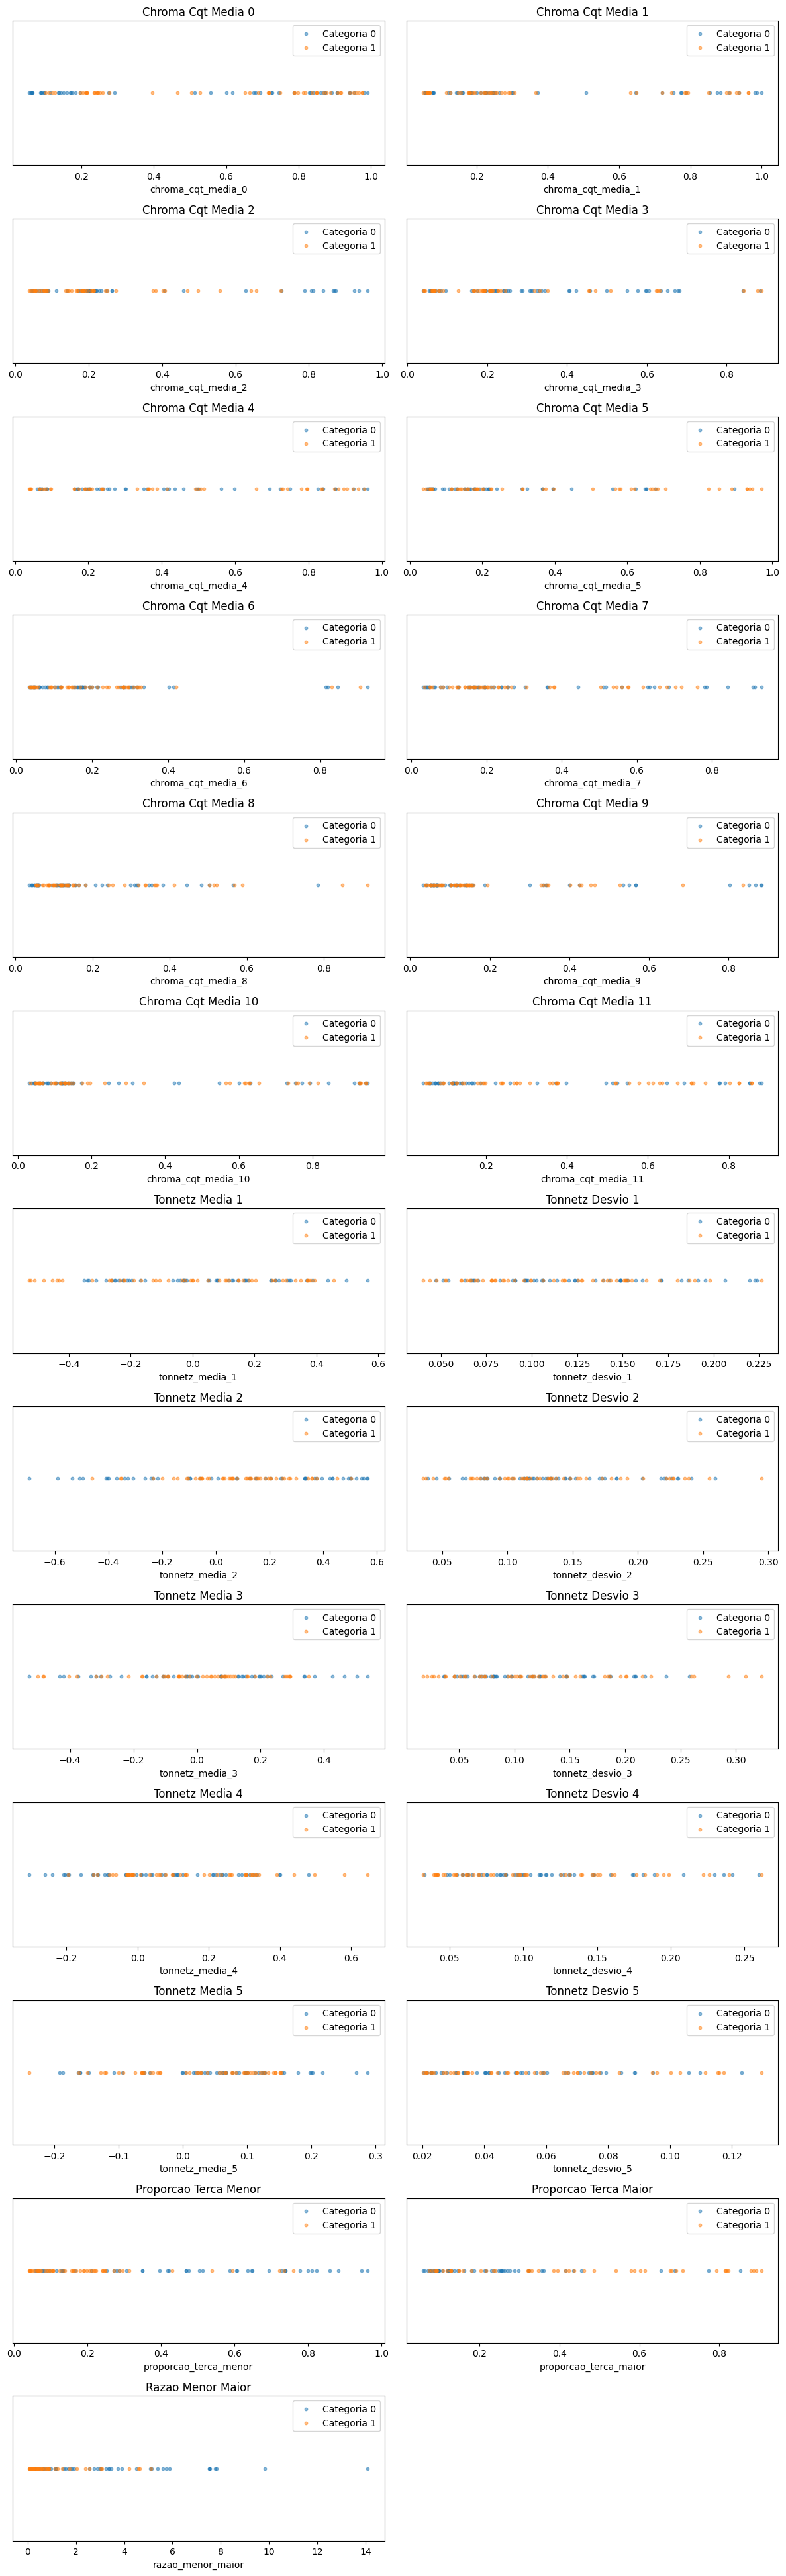


2. Gráficos de dispersão 2D:


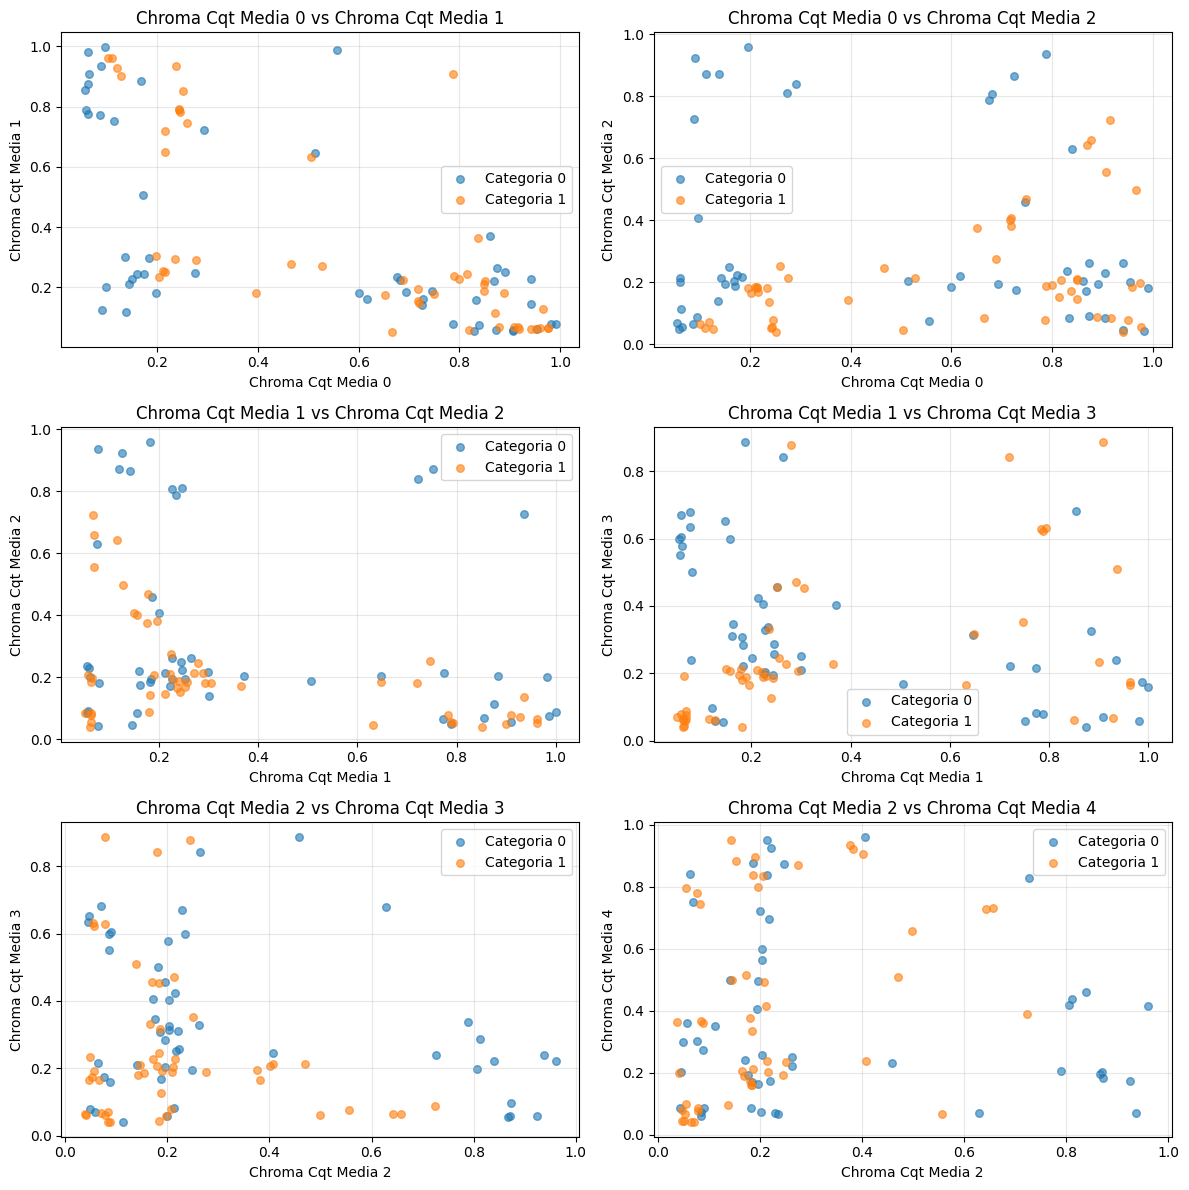

In [19]:
# Célula 4: Visualização e Análise Gráfica dos Dados
def criar_graficos_distribuicao(dados_caracteristicas, rotulos_classe, caracteristicas_selecionadas):
    classes_unicas = np.unique(rotulos_classe)
    num_linhas = math.ceil(len(caracteristicas_selecionadas) / 2)

    plt.figure(figsize=(12, 3 * num_linhas))
    paleta_cores = ['tab:blue', 'tab:orange']

    for indice, caracteristica in enumerate(caracteristicas_selecionadas):
        plt.subplot(num_linhas, 2, indice + 1)
        for posicao, classe in enumerate(classes_unicas):
            dados_filtrados = dados_caracteristicas[rotulos_classe == classe][caracteristica]
            coordenadas_y = [0] * len(dados_filtrados)

            plt.scatter(dados_filtrados, coordenadas_y,
                       label=f"Categoria {classe}",
                       color=paleta_cores[posicao],
                       alpha=0.5,
                       s=10)

        titulo_formatado = caracteristica.replace('_', ' ').title()
        plt.title(titulo_formatado)
        plt.xlabel(caracteristica)
        plt.yticks([])
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.legend()

    plt.tight_layout()
    plt.show()

def criar_graficos_2d(dados_caracteristicas, rotulos_classe, caracteristicas_selecionadas):
    """Cria gráficos de dispersão 2D para pares de características"""
    classes_unicas = np.unique(rotulos_classe)
    paleta_cores = ['tab:blue', 'tab:orange']

    # Selecionar alguns pares importantes de características
    pares_caracteristicas = []
    num_caracteristicas = len(caracteristicas_selecionadas)

    # Criar pares das primeiras características ou todas se forem poucas
    if num_caracteristicas <= 4:
        for i in range(num_caracteristicas):
            for j in range(i+1, num_caracteristicas):
                pares_caracteristicas.append((caracteristicas_selecionadas[i], caracteristicas_selecionadas[j]))
    else:
        # Para muitas características, selecionar alguns pares importantes
        for i in range(min(3, num_caracteristicas)):
            for j in range(i+1, min(i+3, num_caracteristicas)):
                pares_caracteristicas.append((caracteristicas_selecionadas[i], caracteristicas_selecionadas[j]))

    # Limitar o número de gráficos
    pares_caracteristicas = pares_caracteristicas[:6]

    num_linhas = math.ceil(len(pares_caracteristicas) / 2)
    plt.figure(figsize=(12, 4 * num_linhas))

    for indice, (carac_x, carac_y) in enumerate(pares_caracteristicas):
        plt.subplot(num_linhas, 2, indice + 1)

        for posicao, classe in enumerate(classes_unicas):
            mascara_classe = rotulos_classe == classe
            dados_x = dados_caracteristicas[mascara_classe][carac_x]
            dados_y = dados_caracteristicas[mascara_classe][carac_y]

            plt.scatter(dados_x, dados_y,
                       label=f"Categoria {classe}",
                       color=paleta_cores[posicao],
                       alpha=0.6,
                       s=30)

        titulo_x = carac_x.replace('_', ' ').title()
        titulo_y = carac_y.replace('_', ' ').title()

        plt.title(f'{titulo_x} vs {titulo_y}')
        plt.xlabel(titulo_x)
        plt.ylabel(titulo_y)
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def visualizar_dados_completos():
    print("Preparando visualizações dos dados...")
    lista_caracteristicas = dataframe_caracteristicas.columns.tolist()

    print("1. Gráficos de distribuição 1D:")
    criar_graficos_distribuicao(dataframe_caracteristicas, rotulos_dados, lista_caracteristicas)

    print("\n2. Gráficos de dispersão 2D:")
    criar_graficos_2d(dataframe_caracteristicas, rotulos_dados, lista_caracteristicas)

visualizar_dados_completos()

In [20]:
class ClassificadorKNN:
    def __init__(self, num_vizinhos):
        self.num_vizinhos = num_vizinhos
        self.dados_treino = None
        self.rotulos_treino = None

    def treinar(self, X, y):
        self.dados_treino = np.array(X)
        self.rotulos_treino = np.array(y)

    def predizer(self, X):
        predicoes = []
        for amostra in X:
            # Calcula distância euclidiana para todas as amostras de treino
            distancias = np.sqrt(np.sum((self.dados_treino - amostra) ** 2, axis=1))

            # Encontra os k vizinhos mais próximos
            indices_proximos = np.argsort(distancias)[:self.num_vizinhos]
            rotulos_vizinhos = self.rotulos_treino[indices_proximos]

            # Voto majoritário
            valores_unicos, contagens = np.unique(rotulos_vizinhos, return_counts=True)
            classe_predita = valores_unicos[np.argmax(contagens)]
            predicoes.append(classe_predita)

        return np.array(predicoes)

def preparar_conjunto_dados(df_caracteristicas, rotulos_alvo, atributos_escolhidos=None):
    if atributos_escolhidos is None:
        atributos_escolhidos = df_caracteristicas.columns.values

    matriz_X = df_caracteristicas[atributos_escolhidos].values
    vetor_y = np.array(rotulos_alvo)

    # Normalização dos dados
    normalizador = StandardScaler()
    matriz_X_normalizada = normalizador.fit_transform(matriz_X)

    return matriz_X_normalizada, vetor_y

def busca_otima_hiperparametros(X, y, k_maximo=15, num_divisoes=10):
    tamanho_amostra = len(X)
    indices_embaralhados = np.arange(tamanho_amostra)
    np.random.seed(42)
    np.random.shuffle(indices_embaralhados)

    tamanho_fold = tamanho_amostra // num_divisoes
    melhor_k, melhor_pontuacao = 1, 0

    for k_atual in range(1, k_maximo + 1, 2):
        pontuacoes_fold = []

        for fold in range(num_divisoes):
            inicio = fold * tamanho_fold
            fim = (fold + 1) * tamanho_fold if fold != num_divisoes - 1 else tamanho_amostra

            indices_validacao = indices_embaralhados[inicio:fim]
            indices_treinamento = np.concatenate((indices_embaralhados[:inicio],
                                                indices_embaralhados[fim:]))

            X_treino, X_validacao = X[indices_treinamento], X[indices_validacao]
            y_treino, y_validacao = y[indices_treinamento], y[indices_validacao]

            modelo_knn = ClassificadorKNN(num_vizinhos=k_atual)
            modelo_knn.treinar(X_treino, y_treino)
            predicoes = modelo_knn.predizer(X_validacao)

            acuracia = np.mean(predicoes == y_validacao)
            pontuacoes_fold.append(acuracia)

        pontuacao_media = np.mean(pontuacoes_fold)
        if pontuacao_media > melhor_pontuacao:
            melhor_k, melhor_pontuacao = k_atual, pontuacao_media

    return melhor_k, melhor_pontuacao

In [21]:
# Fase 1: Preparação inicial dos dados
conjunto_X, conjunto_y = preparar_conjunto_dados(dataframe_caracteristicas, rotulos_dados)

# Fase 2: Otimização de hiperparâmetros via validação cruzada
print("Executando busca pelo valor ótimo de k...")
k_otimo, acuracia_cv_otima = busca_otima_hiperparametros(conjunto_X, conjunto_y, k_maximo=5, num_divisoes=10)
print(f"Valor ótimo de k: {k_otimo} (acurácia média: {acuracia_cv_otima*100:.1f}% com {len(dataframe_caracteristicas.columns)} características)")

# Verificar características disponíveis e selecionar as relevantes
print(f"\nCaracterísticas disponíveis: {list(dataframe_caracteristicas.columns)}")

Executando busca pelo valor ótimo de k...
Valor ótimo de k: 3 (acurácia média: 86.0% com 25 características)

Características disponíveis: ['chroma_cqt_media_0', 'chroma_cqt_media_1', 'chroma_cqt_media_2', 'chroma_cqt_media_3', 'chroma_cqt_media_4', 'chroma_cqt_media_5', 'chroma_cqt_media_6', 'chroma_cqt_media_7', 'chroma_cqt_media_8', 'chroma_cqt_media_9', 'chroma_cqt_media_10', 'chroma_cqt_media_11', 'tonnetz_media_1', 'tonnetz_desvio_1', 'tonnetz_media_2', 'tonnetz_desvio_2', 'tonnetz_media_3', 'tonnetz_desvio_3', 'tonnetz_media_4', 'tonnetz_desvio_4', 'tonnetz_media_5', 'tonnetz_desvio_5', 'proporcao_terca_menor', 'proporcao_terca_maior', 'razao_menor_maior']


In [22]:
# Fase 3: Seleção de características relevantes (usando nomes corretos das colunas)
caracteristicas_disponiveis = list(dataframe_caracteristicas.columns)
caracteristicas_relevantes = []

# Seleciona características que realmente existem
for nome_caracteristica in caracteristicas_disponiveis:
    if ('chroma_cqt_media_0' in nome_caracteristica or
        'chroma_cqt_media_5' in nome_caracteristica or
        'tonnetz_media_1' in nome_caracteristica or
        'tonnetz_desvio_4' in nome_caracteristica or
        'proporcao_terca_menor' in nome_caracteristica):
        caracteristicas_relevantes.append(nome_caracteristica)

# Se não encontrou características específicas, usa as primeiras 5
if len(caracteristicas_relevantes) == 0:
    caracteristicas_relevantes = caracteristicas_disponiveis[:5]

print(f"Características selecionadas: {caracteristicas_relevantes}")

X_reduzido, y_reduzido = preparar_conjunto_dados(dataframe_caracteristicas, rotulos_dados, atributos_escolhidos=caracteristicas_relevantes)

Características selecionadas: ['chroma_cqt_media_0', 'chroma_cqt_media_5', 'tonnetz_media_1', 'tonnetz_desvio_4', 'proporcao_terca_menor']


In [23]:
# Fase 4: Avaliação final do modelo
X_treino_final, X_teste_final, y_treino_final, y_teste_final = train_test_split(
    X_reduzido, y_reduzido, test_size=0.2, random_state=42)

modelo_final = ClassificadorKNN(num_vizinhos=k_otimo)
modelo_final.treinar(X_treino_final, y_treino_final)
predicoes_finais = modelo_final.predizer(X_teste_final)
acuracia_final = np.mean(predicoes_finais == y_teste_final)

print(f"\nDesempenho final: {acuracia_final*100:.1f}% de acurácia com {len(caracteristicas_relevantes)} características e k={k_otimo}")


Desempenho final: 90.0% de acurácia com 5 características e k=3
